# Modelling irregular bodies shape via ANNs
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body and be trained to reproduce a known gravitational potential field.

To get statically stable asteroids we use results from MPIA work by Francesco Biscani obtained during simulation of protoplanetary formation made by large n-body simulations. Data are included as a submodule in the git project.

To run this notebook create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib
 conda install -c open3d-admin open3d
```

And you will need pytorch (CPU is enough) for the ANN part


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

%matplotlib notebook

# Loading and visualizing an asteroid as a point cloud

In [2]:
# We import the data from MPIA containing pseudo-stable asteroid shapes
f = h5py.File('sample_vis_data/sample_01/state_10567.hdf5','r')
f2 = h5py.File('sample_vis_data/sample_01/global.hdf5', 'r')

In [3]:
# The file state_ ... contains the positions of all particles as well as the indices
# of those belonging to a cluster. Here we extract the largest ones.
dims = [(len(f[cluster][()]), cluster) for cluster in f.keys() if 'cluster' in cluster]
largest_clusters = sorted(dims,reverse=True)

In [4]:
# We have ordered the largest asteroids, we now extract positions for one in particular
rank = 4
print("Target: ", largest_clusters[rank][1])
# The particles idxs for this cluster
idx = f[largest_clusters[rank][1]][()]
# The particle radius
radius = f2['radius'][()]
# Particle positions
x_raw = f['x'][()][idx]
y_raw = f['y'][()][idx]
z_raw = f['z'][()][idx]
print("Diameter: ", 2 * radius)

Target:  cluster_2400
Diameter:  0.00043088693800637674


In [5]:
from sklearn.neighbors import NearestNeighbors
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x_raw, np.append(y_raw,z_raw))
point_cloud = point_cloud.reshape((3,len(x_raw)))
point_cloud = np.transpose(point_cloud)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

# We take out particles that are not "touching" at least two neighbours
unstable_points = np.where(distances[:, 3]> 2 * radius * 1.01)[0]
print("Number of unstable points: ", len(unstable_points))
x = np.delete(x_raw, unstable_points, 0)
y = np.delete(y_raw, unstable_points, 0)
z = np.delete(z_raw, unstable_points, 0)

Minimum distance between particles:  0.00042108838275198475
Maximum distance between particles:  0.0005132013991266676
Number of unstable points:  5


In [6]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
# We normalize so that the axes are at most one
max_value = max([max(abs(it)) for it in [x,y,z]])
x = x / max_value
y = y / max_value
z = z / max_value
plot_radius = radius /  max_value  * 3000
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x, np.append(y,z))
point_cloud = point_cloud.reshape((3,len(x)))
point_cloud = np.transpose(point_cloud)

### Visualization via matplotlib

<IPython.core.display.Javascript object>


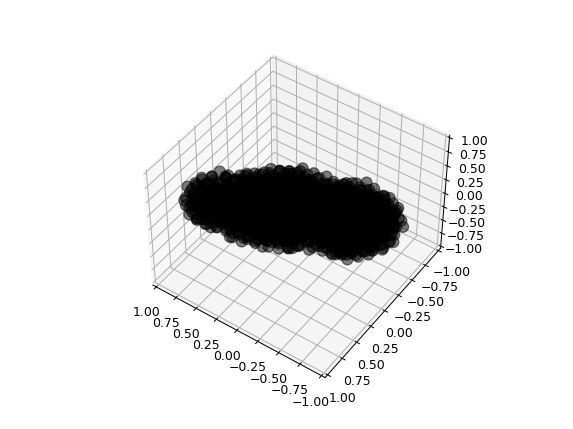

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

# We color the points w.r.t. their distance to the center
color = [np.linalg.norm([point]) for point in point_cloud] 
# And visualize the masses
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, color = 'k', s = plot_radius/2, alpha=0.5)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(elev=45., azim=125.)

### Visualization via open3d

In [8]:
import numpy as np
import open3d as o3d

colors = np.exp(-np.array(color))
colors = np.append(np.append(colors, colors), colors).reshape((3, len(color))).transpose()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.colors = o3d.utility.Vector3dVector(colors)


hull, _ = pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcd, hull_ls])

# Computing the gravitational potential of an asteroid (point cloud) in a point 
The Canvendish constant is not included (or $G=1$), so that we have:
$$
U_L = - \sum_{i=1}^N \frac{m_i}{|\mathbf x - \mathbf r_i|}
$$
where, assuming the asteroid with a unitary mass $m_i = 1/N$, hence:
$$
U_L = - \frac 1N \sum_{i=1}^N \frac{1}{|\mathbf x - \mathbf r_i|}
$$

In [9]:
def U_L(r, point_cloud):
    retval=torch.empty(len(r),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, radius in enumerate(r):
        retval[i] = torch.mean(1./torch.norm(torch.sub(point_cloud,radius), dim=1))
    return - retval 

In [10]:
tcp = torch.tensor(point_cloud)
r = torch.rand(100,3)

In [11]:
%timeit U_L(r, point_cloud=tcp)

56.8 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Representing the asteroid via a neural network


## Approach N.1: A FFNN represents the asteroid surface
In this approach we try to represent the asteroid minimalistically via its surface. Assuming an internal uniform density we will then be able to compute the potential generated at some point.

The FFNN will get three inputs (expressing in a continuous fashion a direction as a unit vector) and output the distance of the asteroid surface from the origin in that particular direction.

In [16]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data, -1, 1)
        nn.init.uniform_(m.bias.data, -0.1, 0.1)

# Initializing a FFNN with three inputs (cartesian components of the unit direction vector) 
# and one output (the asteroid radius)
model = nn.Sequential(
          nn.Linear(3,10),
          nn.Tanh(),
          nn.Linear(10,10),
          nn.Tanh(),
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_ = model.apply(weights_init)



In [17]:
# Creating N equally spaced unit vectors on a sphere (to then plot r)
N = 40
inputs = []
u, v = torch.meshgrid((torch.linspace(0., 1., N), torch.linspace(0, 1, N)))
theta, phi = 2 * np.pi * u, torch.acos(2.*v-1.)
x = torch.sin(phi)*torch.cos(theta)
y = torch.sin(phi)*torch.sin(theta)
z = torch.cos(phi)
inputs = torch.cat((x.view(-1,1),y.view(-1,1), z.view(-1,1)), dim = 1)


In [18]:
# For plotting no gradients are needed
r = model(inputs).detach()

<IPython.core.display.Javascript object>


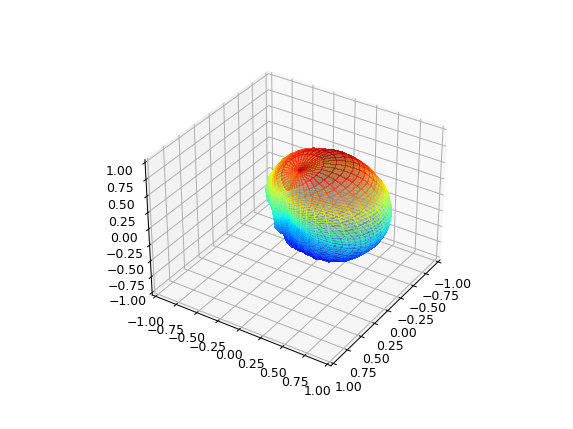

(-1.0, 1.0)

In [19]:
# We plot the visual representation of the asteroid
THETA, PHI = theta, phi
R = r.view((N,N))

X = R * torch.sin(PHI) * torch.cos(THETA)
Y = R * torch.sin(PHI) * torch.sin(THETA)
Z = R * torch.cos(PHI)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X.numpy(), Y.numpy(), Z.numpy(), rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
    linewidth=0, antialiased=False, alpha=0.5)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

## Computing the gravitational potential of the asteroid ANN model

We have a representation of the asteroid surface (and hence volume) given by our ANN, we may then assume a uniform internal density and  compute the resulting potential at a given point $\mathbf x$ as:

$$
U_P = \int_V \rho \frac1{|\mathbf r - \mathbf x|} dV = \rho \int_V \frac{dV}{|\mathbf r - \mathbf x|} 
$$

to compute the integral we use Monte Carlo integration methods, that is we sample N points in a volume V = [-1,1]x[-1,1]x[-1,1] that we know contains our asteroid (as ensured by the sigmoid activation function of the last layer). We then approximate:

$$
U_P(\mathbf x) = \rho\frac V N  \sum_i^N \left\{\begin{array}{ll}\frac{1}{|\mathbf r_i - \mathbf x|} & \mbox{inside the asteroid} \\ 0 &  \mbox{otherwise}  \end{array}\right.
$$

Since $\rho = \frac MV$ is itself an integral being $V = \int_V dV \approx \frac N{N_{in}V}$ we get:

$$
U_P(\mathbf x) = \frac 1{N_{in}}  \sum_i^N \left\{\begin{array}{ll}\frac{1}{|\mathbf r_i - \mathbf x|} & \mbox{inside the asteroid} \\ 0 &  \mbox{otherwise}  \end{array}\right.
$$

In [20]:
def U_P(r, model, N = 300):
    # We generate randomly 300 points in the [-1,1]^3 bounds
    points = torch.rand(N,3) * 2 - 1
    # We compute their norms
    norms = torch.norm(points, dim=1)
    # We compute if they are inside or outside the asteroid represented by the FFNN model
    inside = norms.view(-1,1) < model(points/norms.view(-1,1))
    # Only for the points inside we accumulate the integrand (MC method)
    retval = torch.sum(1./torch.norm(r - points[inside.view(-1,)], dim=1))
    return  - retval / torch.sum(inside)

In [21]:
# Helper class to represent a sphere model
class sphere:
    def __init__(self, N = 300):
        self.N = N
    def __call__(self, x):
        return torch.ones(self.N,1)

spherical_asteroid = sphere(N = 3000)
NN_asteroid = model

target_r = torch.tensor([[1.,1.,1.]])

# We print the values of the potential in r of a sphere, of the ground truth asteroid (point cloud)
# and of the asteroid as represented by the NN
print("Potential of the asteroid represented by the NN (MC): ", U_P(target_r, NN_asteroid, N=3000).item())
print("Potential of a spherical asteroid (MC): ", U_P(target_r, spherical_asteroid, N=3000).item())
print("Potential of a spherical asteroid (Real): ", (-1./torch.norm(target_r)).item())
print("Potential of the point cloud: (Real)", U_L(target_r, point_cloud=tcp)[0][0].item())

Potential of the asteroid represented by the NN (MC):  -0.5987290321682037
Potential of a spherical asteroid (MC):  -0.5755055019505035
Potential of a spherical asteroid (Real):  -0.5773502691896258
Potential of the point cloud: (Real) -0.6077760177440209


In [22]:
# All good, but can we get the gradient of the above potential w.r.t. the weights? -> NOPE
# So the only way to evolve this network is EVOLUTION!!!
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://insight-quality.com/wp-content/uploads/2018/04/problem.jpg")

## Approach N.2: A FFNN represents the asteroid density
In this approach we try to represent the asteroid density $\rho$ directly! This may seem worse
but, in terms of gradients, leads to a more learnable problem.

In [27]:
# Network architecture
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data, -1, 1)
        nn.init.uniform_(m.bias.data, -0.1, 0.1)

# Initializing a FFNN with four inputs and one output (the density).
# The four inputs are ix, iy, iz, r corresponding to the cartesian point P = r [ix, iy, iz]
model = nn.Sequential(
          nn.Linear(4,30),
          nn.ReLU(),
          nn.Linear(30,30),
          nn.ReLU(),
          nn.Linear(30,30),
          nn.ReLU(),
          nn.Linear(30,30),
          nn.ReLU(),
          nn.Linear(30,10),
          nn.ReLU(),
          nn.Linear(10,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_  = model.apply(weights_init)

In [28]:
# Converts a cartesian position x,y,z into a network input ix, iy, iz, r
def cart2inputs(x):
    unit_x = x / torch.norm(x,dim=1).view(-1,1)
    return torch.cat((unit_x, torch.norm(x,dim=1).view(-1,1)), dim=1)

In [29]:
# To visualize the network output in the box [-1,1]^3 we compute the NN output on a grid 
x = torch.linspace(-1,1,20)
y = torch.linspace(-1,1,20)
z = torch.linspace(-1,1,20)
X, Y, Z = torch.meshgrid((x,y,z))
nn_inputs = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)), dim=1)
nn_inputs = cart2inputs(nn_inputs)
RHO = model(nn_inputs).detach()


<IPython.core.display.Javascript object>


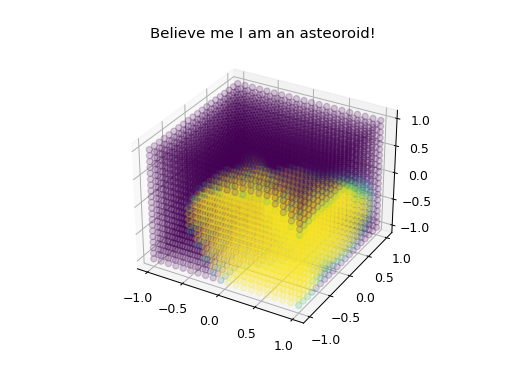

Text(0.5, 0.92, 'Believe me I am an asteoroid!')

In [30]:
# Here we plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), marker='.', c=RHO, s=100, alpha=0.2)
plt.title("Believe me I am an asteoroid!")

## Computing the gravitational potential of the asteroid ANN model
Having the mass density $\rho$ we may now compute the potential field via a monte carlo integration approach.
In the naive implementation, we will sample at random $N$ points to compute:
$$
U_P = - \int_V \frac\rho r dV 
$$
The volume V is the cube $[-1,1]^3$, with a volume of 8. We thus approximate the above integral as:
$$
U_P(\mathbf r) \approx \frac 8N \sum_i \frac {\rho_i}{|\mathbf r-\mathbf x_i|} 
$$
where $\mathbf x_i$ are $N$ uniformly randomly sampled within the cube -> PLEASE IMPROVE ME!

In [31]:
# This computes the potential at the points r (e.g. torch.tensor([[np.sqrt(2),np.sqrt(2),0], [10,0,0]]))
# from the model
def U_P2(r, model, N = 3000):
    # We generate randomly points in the [-1,1]^3 bounds
    mc_points = torch.rand(N,3) * 2 - 1
    nn_inputs = cart2inputs(mc_points)
    rho = model(nn_inputs)
    retval=torch.empty(len(r),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, radius in enumerate(r):
        retval[i] = torch.sum(rho/torch.norm(radius - mc_points, dim=1).view(-1,1)) / N
    return  - 8 * retval

In [48]:
# The dataset is here produced. It consists on the values of the potentials in 100 points radnomly
# sampled around the asteroid and excluding those that are potentially inside.
targets = (torch.rand(100,3)*2-1)*1.1
targets[torch.norm(targets, dim=1) > 1]
labels = U_L(targets, tcp)

# Here we set some details of the training
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Here we perform steps of gradient descent
Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [ ]:
for i in range(5000):
    # Compute the loss
    predicted = U_P2(targets, model, N=30000)
    loss = loss_fn(predicted, labels)
    print(i, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 0.0013790876514552983
1 0.0013794249493840397
2 0.006140585797034047
3 0.0012909324341031808
4 0.002670417806884942
5 0.0011929220002132315
6 0.0017983733154439375
7 0.001473118337826515
8 0.0018210037523730227
9 0.002879434927289266
10 0.0037684376104805163
11 0.0027398450318339967
12 0.0021095164576577187
13 0.0013481713776749618
14 0.0021333705184457584
15 0.002130132980891326
16 0.0013089343270196211
17 0.0016475122605810039
18 0.0015105616191403992
19 0.0018439896346103696
20 0.0014820708959005337
21 0.001288446254035246
22 0.0016357270646466249
23 0.0020646857308759038
24 0.003952612629989363
25 0.001705013662820057
26 0.004442801415736373
27 0.0015403407861687903
28 0.0015427328294232298
29 0.0016805361837769145
30 0.0015244073160281023
31 0.0016784579269813174
32 0.0015507785138384924
33 0.0011430256320371006
34 0.0024378518986267915
35 0.0035013727308946686
36 0.0019623331474722923
37 0.0013226241846274727
38 0.0015481951022753052
39 0.0017719115243657155
40 0.00132799003425

<IPython.core.display.Javascript object>


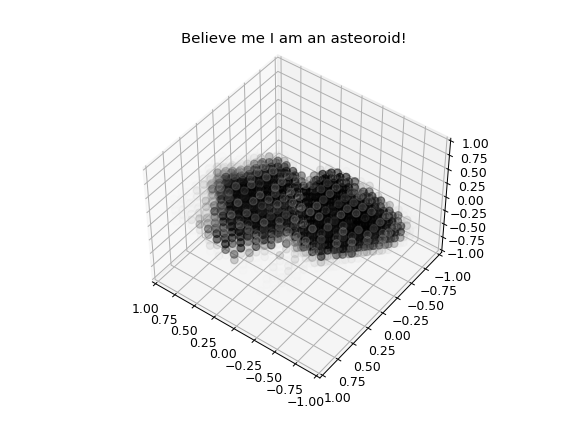

In [44]:
x = torch.linspace(-1,1,20)
y = torch.linspace(-1,1,20)
z = torch.linspace(-1,1,20)
X, Y, Z = torch.meshgrid((x,y,z))
nn_inputs = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)), dim=1)
nn_inputs = cart2inputs(nn_inputs)
RHO = model(nn_inputs).detach()

colors = torch.cat((1-RHO, 1-RHO, 1-RHO, RHO), dim=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), marker='.', c=colors, s=150)
#ax.scatter(targets[:,0], targets[:,1], targets[:,2], color='y')
plt.title("Believe me I am an asteoroid!")

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(elev=45., azim=125.)

<IPython.core.display.Javascript object>


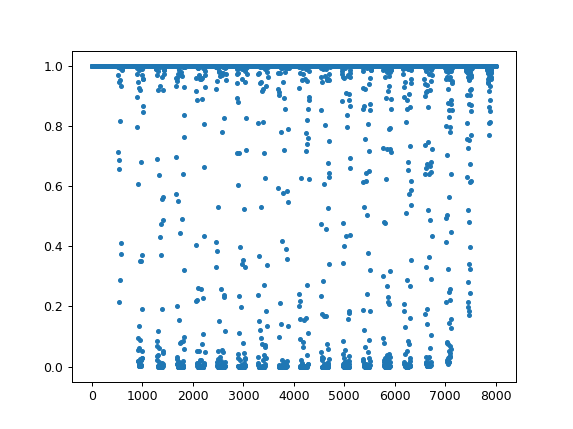

In [306]:
fig = plt.figure()
plt.plot((1-RHO).numpy(), '.')

# TODO list:

* Code efficiency -> move to GPU and make training scalable to more sample points / mc points.
* MC integration -> a better algorithm must exist to sample the points (low-discrepancy maybe?)
* Network architecture -> this is only a possible one. More depth? Different inputs? Use the NERF decomposition in harmonics?
* How to visualize and interpret the results? The matplotlib trick used here should be improved? How do we know how well the asteroid shape and internal mass distributionis learned?
* Propagate trajectories around the asteroid.
* Can we incorporate observations from real spacecraft trajectories in the loss? Or other data-fusion things?
* Training with gravity rather than potential?
* What happens for non uniform bodies? Can we prove that we are able to follow the inhomogenuities?